# Normalization and pre-tokenization

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

Before we dive more deeply into the three most common subword tokenization algorithms used with Transformer models (Byte-Pair Encoding [BPE], WordPiece, and Unigram), we’ll first take a look at the preprocessing that each tokenizer applies to text. Here’s a high-level overview of the steps in the tokenization pipeline:


<img src="https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter6/tokenization_pipeline.svg" width="70%">

Before splitting a text into subtokens (according to its model), the tokenizer performs two steps: **normalization and pre-tokenization**.

In [1]:
from IPython.display import HTML

HTML('<iframe width="430" height="320" src="https://www.youtube.com/embed/4IIC2jI9CaU" title="What is normalization?" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/home/hpshin/.local/lib/python3.6/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


**The normalization step involves some general cleanup, such as removing needless whitespace, lowercasing, and/or removing accents.** If you’re familiar with [Unicode normalization](http://www.unicode.org/reports/tr15/) (such as NFC or NFKC), this is also something the tokenizer may apply.

The 🤗 Transformers tokenizer has an attribute called backend_tokenizer that provides access to the underlying tokenizer from the 🤗 Tokenizers library:

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
print(type(tokenizer.backend_tokenizer))

<class 'tokenizers.Tokenizer'>

The normalizer attribute of the tokenizer object has a normalize_str() method that we can use to see how the normalization is performed:

In [ ]:
print(tokenizer.backend_tokenizer.normalizer.normalize_str("Héllò hôw are ü?"))

'hello how are u?'

In this example, since we picked the bert-base-uncased checkpoint, the normalization applied lowercasing and removed the accents.

✏️ Try it out! Load a tokenizer from the bert-base-cased checkpoint and pass the same example to it. What are the main differences you can see between the cased and uncased versions of the tokenizer?

## Pre-tokenization

In [2]:
from IPython.display import HTML

HTML('<iframe width="430" height="320" src="https://www.youtube.com/embed/grlLV8AIXug" title="What is pre-tokenization?" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

As we will see in the next sections, a tokenizer cannot be trained on raw text alone. Instead, we first need to split the texts into small entities, like words. That’s where the pre-tokenization step comes in. As we saw in [Chapter 2](https://huggingface.co/course/chapter2), a word-based tokenizer can simply split a raw text into words on whitespace and punctuation. Those words will be the boundaries of the subtokens the tokenizer can learn during its training.

To see how a fast tokenizer performs pre-tokenization, we can use the pre_tokenize_str() method of the pre_tokenizer attribute of the tokenizer object:


In [ ]:
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

[('Hello', (0, 5)), (',', (5, 6)), ('how', (7, 10)), ('are', (11, 14)), ('you', (16, 19)), ('?', (19, 20))]

**Notice how the tokenizer is already keeping track of the offsets, which is how it can give us the offset mapping we used in the previous section.** Here the tokenizer ignores the two spaces and replaces them with just one, but the offset jumps between are and you to account for that.

Since we’re using a BERT tokenizer, the pre-tokenization involves splitting on whitespace and punctuation. Other tokenizers can have different rules for this step. For example, if we use the GPT-2 tokenizer:

it will split on whitespace and punctuation as well, but it will keep the spaces and replace them with a Ġ symbol, enabling it to recover the original spaces if we decode the tokens:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

[('Hello', (0, 5)), (',', (5, 6)), ('Ġhow', (6, 10)), ('Ġare', (10, 14)), ('Ġ', (14, 15)), ('Ġyou', (15, 19)),
 ('?', (19, 20))]

Also note that unlike the BERT tokenizer, this tokenizer does not ignore the double space.

For a last example, let’s have a look at the T5 tokenizer, which is based on the **SentencePiece** algorithm:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

[('▁Hello,', (0, 6)), ('▁how', (7, 10)), ('▁are', (11, 14)), ('▁you?', (16, 20))]

Like the GPT-2 tokenizer, this one keeps spaces and replaces them with a specific token (_), but the T5 tokenizer only splits on whitespace, not punctuation. Also note that it added a space by default at the beginning of the sentence (before Hello) and ignored the double space between are and you.

Now that we’ve seen a little of how some different tokenizers process text, we can start to explore the underlying algorithms themselves. We’ll begin with a quick look at the broadly widely applicable SentencePiece; then, over the next three sections, we’ll examine how the three main algorithms used for subword tokenization work.


## SentencePiece

[SentencePiece](https://github.com/google/sentencepiece) is a tokenization algorithm for the preprocessing of text that you can use with any of the models we will see in the next three sections. It considers the text as a **sequence of Unicode characters**, and replaces spaces with a special character, ▁. Used in conjunction with the Unigram algorithm (see [section 7](https://huggingface.co/course/chapter7/7), it doesn’t even require a pre-tokenization step, which is very useful for languages where the space character is not used (like Chinese or Japanese).

The other main feature of SentencePiece is **reversible tokenization**: since there is no special treatment of spaces, decoding the tokens is done simply by concatenating them and replacing the _s with spaces — this results in the normalized text. As we saw earlier, the BERT tokenizer removes repeating spaces, so its tokenization is not reversible.

## Algorithm overview

In the following sections, we’ll dive into the three main subword tokenization algorithms: **BPE (used by GPT-2 and others), WordPiece (used for example by BERT), and Unigram (used by T5 and others)**. Before we get started, here’s a quick overview of how they each work. Don’t hesitate to come back to this table after reading each of the next sections if it doesn’t make sense to you yet.

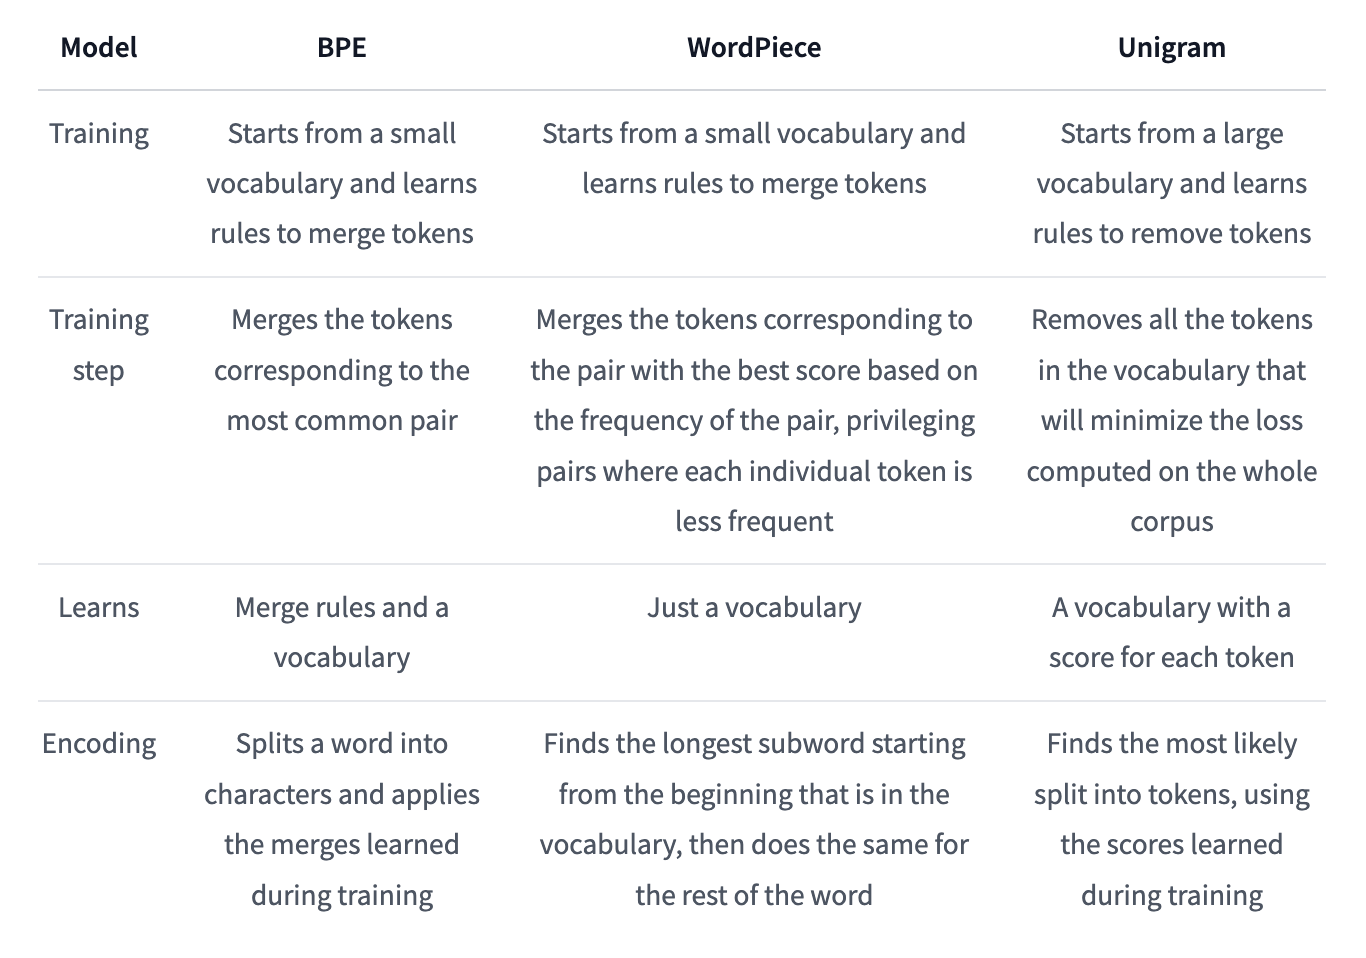

Now let’s dive into BPE!